# CASH-4378: Build ARIMA Forecast strategy Guideline

## Part 1: ARIMA model building and the time series analysis approach to forecasting

### Goal:

Due to its ability to inform decision-making and strategy, time series forecasting is vital in countless fields. By accurately predicting future values, businesses and organizations can optimize resources, minimize risks and capitalize on opportunities. 

Importance of time series forecasting in trucking: 

* Shippers can use rate forecasting to strengthen the core processes of procurement, budgeting, surge pricing, and carrier relations;
* Leveraging the power of forecasting in these four critical areas will enable shippers to build healthier transportation networks, increase customer satisfaction, and boost efficiency and profitability for their organizations and for their strategic carrier partners;
*  Rate forecasts can pinpoint when and where the spot market is expected to heat up to make necessary cost adjustments to retain capacity in tight markets.

* Procurement:
  * The data helps shippers smooth the negotiating process with carriers during “mini-bid” events on a scheduled or ad hoc basis;
  * Rate forecasts can be combined with historical analysis to plan for seasonal patterns and make pricing adjustments to retain capacity.

* Budgeting:
  * Accurate rate forecasts can build flexibility into their budgets to better manage uncertainty and volatility in spot and contract freight markets.
  * Help shippers better leverage forecasting insights to project costs for both spot and contract rate categories in their overall network and for specific lanes.

* Market surge:
  * The freight market is impacted by dynamic changes in the supply of truckload capacity and demand to
move shippers’ load volumes. When demand outpaces supply, surges result. Barring unforeseen events like a global pandemic or severe weather, most cycles in the market are predictable.

* Carrier relations:
  * Rate forecasts help shippers to establish fair rates with strategic carrier partners to keep contracts aligned more closely with market rates throughout the year;
  * By using rate analytics and forecasting, shippers can see if the rates they are paying carriers — or the rates they are receiving from bids — are aligned with the market.

* ARIMA intuition:
  * ARIMA is a method for forecasting or predicting future outcomes based on a historical time series. It is based on the statistical concept of serial correlation, where past data points influence future data points.

In [1]:
# Load required packages
import matplotlib
from pricing_analysis_utils import read_cached_sql
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

sns.set()

## ARIMA/SARIMAX
from math import sqrt

# import necessary libraries
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from datetime import timedelta


## Chart options
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Supressing warnings
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Format settings:
pd.set_option("display.float_format", lambda x: "%.4f" % x)

### Get TRAC rates from selected lanes V0 

TRAC lanes were originally denified on CASH-4305:

You can either extract then from a s3 file or trino table.

In [4]:
# ## Extract files from aws S3 and save it on a file path
! aws s3 cp  s3://loadsmart-data-science/pricing-analysis/CASH-4305/df_trac_selected_lanes_rates.csv .

### Table trino: s3_silver.trac.lanes

Completed 256.0 KiB/22.6 MiB (177.8 KiB/s) with 1 file(s) remaining
Completed 512.0 KiB/22.6 MiB (343.7 KiB/s) with 1 file(s) remaining
Completed 768.0 KiB/22.6 MiB (499.2 KiB/s) with 1 file(s) remaining
Completed 1.0 MiB/22.6 MiB (631.2 KiB/s) with 1 file(s) remaining  
Completed 1.2 MiB/22.6 MiB (760.1 KiB/s) with 1 file(s) remaining  
Completed 1.5 MiB/22.6 MiB (867.5 KiB/s) with 1 file(s) remaining  
Completed 1.8 MiB/22.6 MiB (980.2 KiB/s) with 1 file(s) remaining  
Completed 2.0 MiB/22.6 MiB (1.1 MiB/s) with 1 file(s) remaining    
Completed 2.2 MiB/22.6 MiB (1.2 MiB/s) with 1 file(s) remaining    
Completed 2.5 MiB/22.6 MiB (1.2 MiB/s) with 1 file(s) remaining    
Completed 2.8 MiB/22.6 MiB (1.3 MiB/s) with 1 file(s) remaining    
Completed 3.0 MiB/22.6 MiB (1.4 MiB/s) with 1 file(s) remaining    
Completed 3.2 MiB/22.6 MiB (1.5 MiB/s) with 1 file(s) remaining    
Completed 3.5 MiB/22.6 MiB (1.5 MiB/s) with 1 file(s) remaining    
Completed 3.8 MiB/22.6 MiB (1.6 MiB/s) with 1 fi

In [104]:
## Get selected Dry Van lanes previously defined
df_trac = pd.read_csv("df_trac_selected_lanes_rates.csv")
df_trac.set_index("data_timestamp", inplace=True)

## fill in missing data
df_trac = df_trac.fillna(method="ffill").fillna(method="bfill")

## Select a few lanes to run ARIMA:

#### The chosen lanes are among the SG TOP Lanes previously identified

In [106]:
df_arima = df_trac[["442-286", "410-601", "917-841", "770-300"]]
df_arima.index = pd.to_datetime(df_arima.index)

# Get datapoints of every Friday
df_arima_f = df_arima[df_arima.index.day_name() == "Friday"]

### Time-series chart visualization

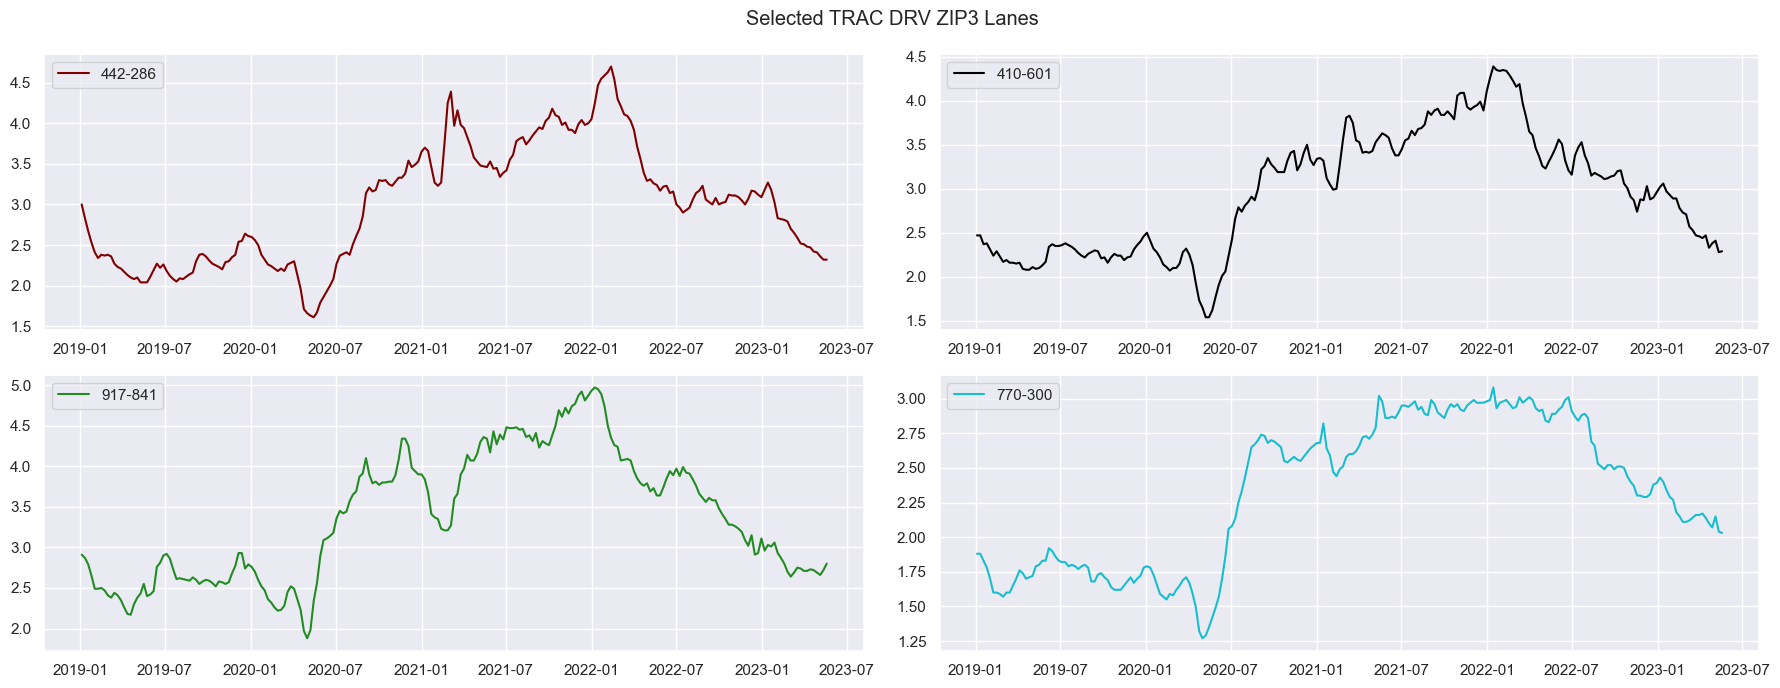

In [107]:
fig = plt.figure(figsize=(18, 7))

plt.suptitle("Selected TRAC DRV ZIP3 Lanes")
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(df_arima_f["442-286"], label="442-286", color="maroon")
# ax1.axhline(y=2.51, color="b", linestyle="--")
plt.legend()
# lane 2
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(df_arima_f["410-601"], label="410-601", color="black")

plt.legend()

# Lane 3
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(df_arima_f["917-841"], label="917-841", color="forestgreen")
plt.legend()
# Lane 4
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(df_arima_f["770-300"], label="770-300", color="tab:cyan")

plt.legend()

[ax.legend(loc=2) for ax in plt.gcf().axes]

plt.tight_layout()

plt.show()

### Key takeaways: 

* Seasonaliuty: 
  * There isn't a clear trend and no repetitive patterns -- no calendar effect (important to define seasonal hyperparameters).

* Stationarity:
  * Stationary data is defined as not depending on the time component and possesses the following characteristics, constant mean, constant variance overtime and constant autocorrelation structure (i.e., the pattern of autocorrelation does not change over time), without periodic or seasonal component.
  * The visualization above indicates that the time series follows trends in different periods, whether upward, sideway or downward, which makes the statistical characteristics not constant over time. Hence, suggesting that the data is non-stationary. To quantify it stationarity, we can use following two methods.

* How to avoid non-stationary issues?
  * Differencing removes trend and seasonality by computing the differences between an observation and its subsequent observations, differencing can transform some non-stationary data to stationary.

## ARIMA (p,d,q) Autoregressive Integrated Moving Average

$ y_t = c + \sum_{i=1}^{p}\beta_i y_{t-i} + \sum_{i=1}^{q}\theta_i \epsilon_{t-i} $


ARIMA models combine three distinct components:

* Autoregression (AR $ \rightarrow p$)
* Differencing (I $ \rightarrow d$) 
* Moving average (MA $ \rightarrow q$)

The autoregressive component captures the relationship between an observation and a predetermined number of lagged observations. Meanwhile, differencing is used to make a non-stationary time series stationary. And finally, the moving average component accounts for the impact of past errors on the current observation.

One can think the constant term $c$ as the long-term path of the series; 

Since I am looking for short-term forecasts, I do not need to woory with seasonal patterns (calendar effects). Besides, if some one decideds to evaluate a ACF function to see if there is any seasonal pattern, graphical analysis does not indicate the presence of this effect.

#### Forecasting:
It extrapolates the local trend at the end of the series but flattens it out at longer forecast horizons to introduce a note of conservatism, a practice that has empirical support

## ARIMA Modelling:

### Single Timeseries: Quinck guide to perfrom and evaluate time-series ARIMA modeling:

In [108]:
# get actual data for county Polk
data_actual = df_arima_f["442-286"]

# use pmdarima to automatically select best ARIMA model
model = pm.auto_arima(
    data_actual,
    test="adf",  # use adftest augmented Dickey-Fuller test to find optimal 'd'
    # m=12,               # frequency of series
    # seasonal=seasonal,  # TRUE if seasonal series
    d=None,  # let model determine 'd'
    ##Settings parameters (weights) range:
    start_p=0,
    start_q=0,  # minimum p and q
    max_p=3,
    max_q=3,  # maximum p and q
    # D=None,             # let model determine 'D'
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)

# print model summary
print(model.summary())
aic_value = model.order

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-393.004, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-433.356, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-421.488, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-394.806, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-432.233, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-431.820, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-438.437, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-441.164, Time=0.22 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-438.607, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-441.361, Time=0.41 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-442.195, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-443.263, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-439.979, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-441.820, Time=0.25 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept

## Understanding the model summary:

### ARIMA Mathematical expression:

$ y_t = c + \sum_{i=1}^{p}\beta_i y_{t-i} + \sum_{i=1}^{q}\theta_i \epsilon_{t-i} \rightarrow$  $ y_t = -0.6369 y_{t-1}  + \epsilon_t +  1.0651 \epsilon_{t-1} + 0.4799 \epsilon_{t-2}$

### Model interpretation:

* The auto_arima function performed a stepwise search to find the ARIMA model with the lowest AIC value. It searched through various combinations of the p, d, and q parameters of ARIMA, and the P, D, and Q parameters of seasonal ARIMA (SARIMA) models I have set the model not to fit seasonal compoments. Previously analysis dosen't indicate sesonal patterns on weekly data points. 

* The summary displays the AIC values and estimated model parameters for each candidate model that was evaluated. The best model is determined based on the lowest AIC value, which in this case is a non-seasonal ARIMA(1,1,2) model with an intercept term. 

* The AIC for this model is 445.142, which is the smallest value among all candidate models.

### Model Evaluation 

#### Akaike Information Critieria (AIC) 

AIC = 2k - 2ln(L): which is calculated based on log likelihood (L) and number of parameters(k). We would like to optimize for a model to have less AIC, which means that:

* AIC is used for comparing which model is the best because it penalizes models with lots of parameters for very little fit improvement, thus resulting in simple but effective regressions (similar to avoiding overffiting).

### Residual diagnostics:

* Residual independence Prob(Q) - Autocorrelation Ljung-Box Test :
  * According to the model summary, the model meets the condition of independence in the residuals (no correlation) because the p-value of the Ljung-Box test (Prob(Q)) is greater than 0.05, so we cannot reject the null hypothesis of independence

* Residual distribution is homoscedastic (constant variance):
  * We can say that the residual distribution is homoscedastic (constant variance) because the p-value of the Heteroskedasticity test (Prob(H)) is greater than 0.05;
  *  Heteroscedasticity test reveals that this model does account for all of the variance in the data. 

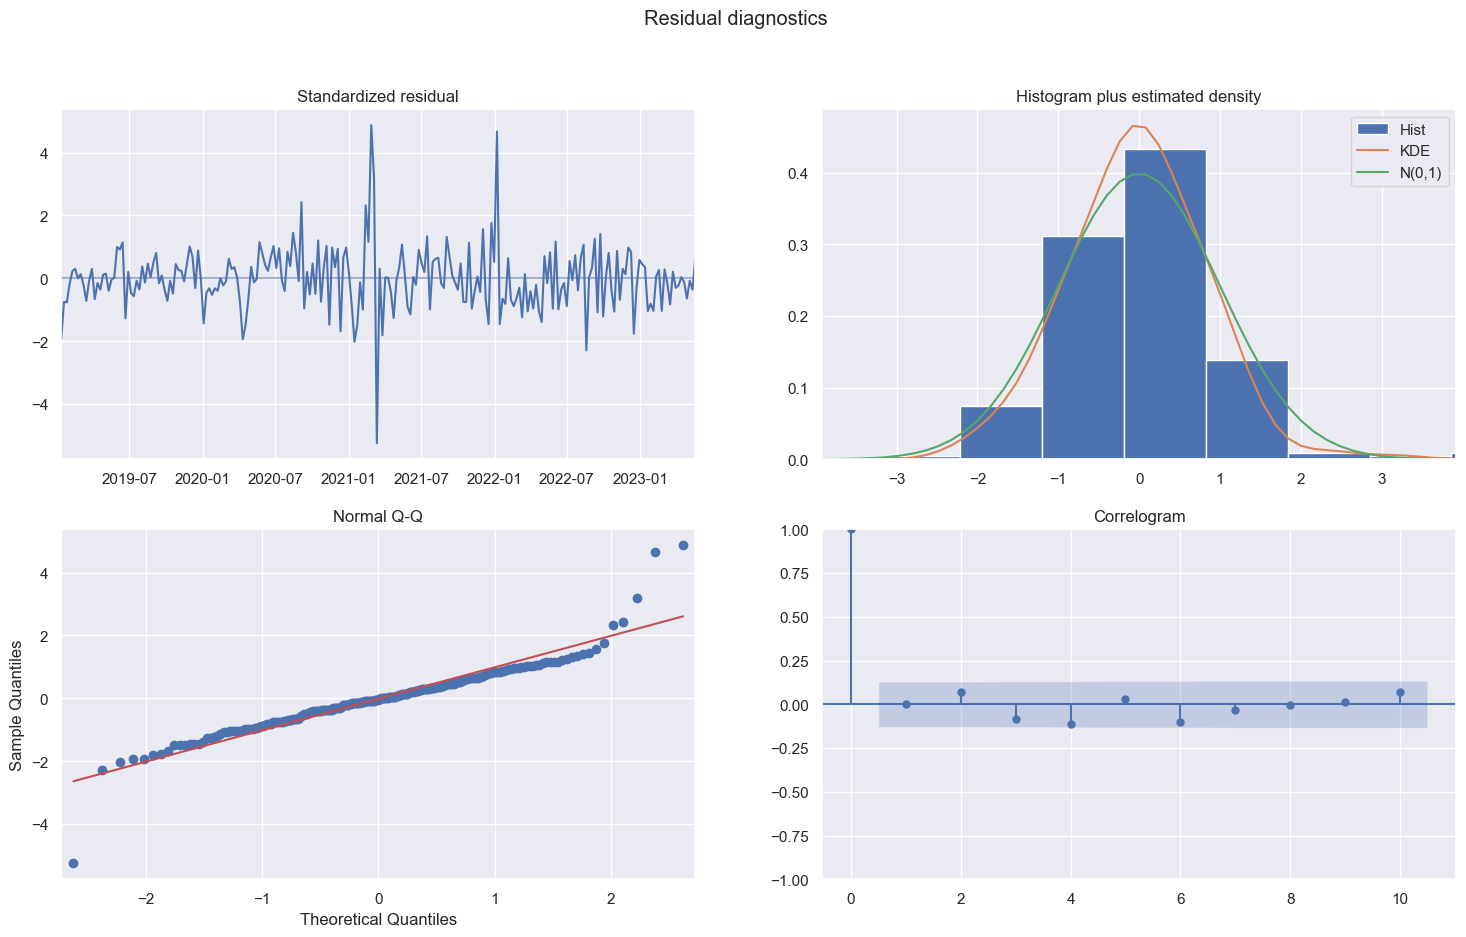

In [93]:
model.plot_diagnostics(figsize=(18, 10))
plt.suptitle("Residual diagnostics")
plt.show()

### Residuals intuition:

* We can see from the model plots that the Correlogram does not show any significant correlation in the residuals. 
* The standardized resual plot depicts variance change; 
* The normal Q-Q plot demonstrates that the residuals do not follow a normal distribution (but this is not a strict requirement to validate the model).

#### Residuals are useful in checking whether a model has adequately captured the information in the data. 

A good forecasting method will yield residuals with the following properties:
  * Residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts;
  * The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

In addition to these essential properties, it is useful (but not necessary) for the residuals to also have the following two properties.

* The residuals have constant variance.
* The residuals are normally distributed.

Overall interpretation: Our model will generate accuarate forecasts (predictions).

## Multiple timeseries:

### Let's loop ARIMA for all selected lanes

In [94]:
def get_forecast_lane(data, n_periods):
    # Initialize empty lists to store forecast data
    data_fc = []
    data_lower = []
    data_upper = []
    data_aic = []
    data_order = []
    data_fitted = []

    # Iterate over columns in data
    for lane in data.columns:
        # Fit an ARIMA model using the auto_arima function
        data_actual = data[lane]
        model = pm.auto_arima(
            data_actual,
            start_p=0,
            start_q=0,
            max_p=12,
            max_q=12,  # maximum p and q
            test="adf",  # use adftest to find optimal 'd'
            d=None,  # let model determine 'd'
            #   seasonal=seasonal,  # TRUE if seasonal series
            # m=7,  # frequency of series
            # D=None,  # let model determine 'D'
            trace=False,
            error_action="ignore",
            suppress_warnings=True,
            stepwise=True,
        )

        # Generate forecast and confidence intervals for n_periods into the future
        fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
        index_of_fc = pd.date_range(
            pd.to_datetime(df_arima_f.index[-1]) + timedelta(days=6),
            periods=n_periods,
            freq="W-FRI",
        )

        # Append forecast data to lists
        data_fc.append(fc)
        data_lower.append(confint[:, 0])
        data_upper.append(confint[:, 1])
        data_aic.append(model.aic())
        data_order.append(model.order)
        data_fitted.append(
            model.fittedvalues()
        )  # Notice that auto arima applies one-step ahead predictions

        # Create dataframes for forecast, lower bound, and upper bound and model statistics
        df_fc = pd.DataFrame(index=index_of_fc)
        df_lower = pd.DataFrame(index=index_of_fc)
        df_upper = pd.DataFrame(index=index_of_fc)
        df_aic = pd.DataFrame()
        df_order = pd.DataFrame()
        df_fitted = pd.DataFrame(index=data_actual.index)

    # Populate dataframes with fit results
    i = 0
    for lane in data.columns:
        df_fc[lane] = data_fc[i][:]
        df_lower[lane] = data_lower[i][:]
        df_upper[lane] = data_upper[i][:]
        df_aic[lane] = data_aic[i]
        df_order[lane] = data_order[i]
        df_fitted[lane] = data_fitted[i][:].iloc[1:]
        i = i + 1

    # Need to drop first row of fitted data - all row value equals to zero because of the recursive ARIMA process
    df_fitted = df_fitted.iloc[1:]
    # Rename df_order index to match ARI<MA hyperparamethers
    df_order = df_order.rename(index={0: "p", 1: "d", 2: "q"})

    return df_fc, df_lower, df_upper, df_aic, df_fitted, df_order

In [95]:
def get_combined_data(df_actual, df_forecast):
    # Assign input data to separate variables
    data_actual = df_actual
    data_forecast = df_forecast

    # Add a 'desc' column to indicate whether the data is actual or forecast
    data_actual["desc"] = "Actual"
    data_forecast["desc"] = "Forecast"

    # Combine actual and forecast data into a single DataFrame and reset the index
    df_act_fc = pd.concat([data_actual, data_forecast]).reset_index()

    # Rename the index column to 'month'
    df_act_fc = df_act_fc.rename(columns={"index": "date"})
    df_act_fc = df_act_fc.set_index("date")
    # Return the combined DataFrame
    return df_act_fc

In [96]:
df_fc, df_lower, df_upper, df_aic, df_fitted, df_order = get_forecast_lane(
    data=df_arima_f, n_periods=1
)

### Best model selection based on AIC Criteria

In [97]:
df_order

,432-296,301-945,231-194,372-282
p,1,5,0,2
d,1,1,1,1
q,0,0,0,1


Noticed that because all series were non-stationary, they all need to be differentiated (shifht(1) - d=1)). 

### Combined actual and forecasted (one-week ahead data points

In [98]:
df_act_fc = get_combined_data(df_actual=df_arima_f, df_forecast=df_fc)
df_act_fc

,432-296,301-945,231-194,372-282,desc
date,,,,,
2019-01-04,2.8600,1.4600,3.8200,2.7200,Actual
2019-01-11,2.6800,1.4000,3.7000,2.6600,Actual
2019-01-18,2.5200,1.4400,3.4900,2.4500,Actual
2019-01-25,2.3700,1.4200,3.3700,2.3700,Actual
2019-02-01,2.2700,1.3900,3.3000,2.2300,Actual
...,...,...,...,...,...
2023-04-28,2.3100,1.6900,3.1800,2.4100,Actual
2023-05-05,2.2700,1.6900,3.3300,2.5900,Actual
2023-05-12,2.2200,1.6900,3.1900,2.5700,Actual


### Error metrics

In [99]:
# Calculkate key error metrics - Compare actual data vs fitted data

mse = ((df_arima_f - df_fitted) ** 2).mean(axis=0)
rmse = np.sqrt(mse)
rmse = pd.DataFrame({"lane": rmse.index, "RMSE": rmse.values})[:-1]

mae = abs((df_arima_f - df_fitted)).mean(axis=0)
mae = pd.DataFrame({"lane": mae.index, "MAE": mae.values})[:-1]

mape = abs((df_arima_f - df_fitted) / df_arima_f).mean(axis=0)
mape = pd.DataFrame({"lane": mape.index, "MAPE": mape.values})[:-1]

mspe = (((df_arima_f - df_fitted) ** 2) / df_arima_f).mean()
rmspe = np.sqrt(mspe)
rmspe = pd.DataFrame({"lane": rmspe.index, "RMSPE": rmspe.values})[:-1]

error_metrics = pd.merge(
    pd.merge(pd.merge(mape, mae, on="lane"), rmse, on="lane"), rmspe, on="lane"
)
error_metrics

,lane,MAPE,MAE,RMSE,RMSPE
0,231-194,0.0261,0.1052,0.1469,0.0713
1,301-945,0.0233,0.0410,0.0611,0.0444
2,372-282,0.0226,0.0683,0.0913,0.0514
3,432-296,0.0181,0.0532,0.0761,0.0424


### Display charts

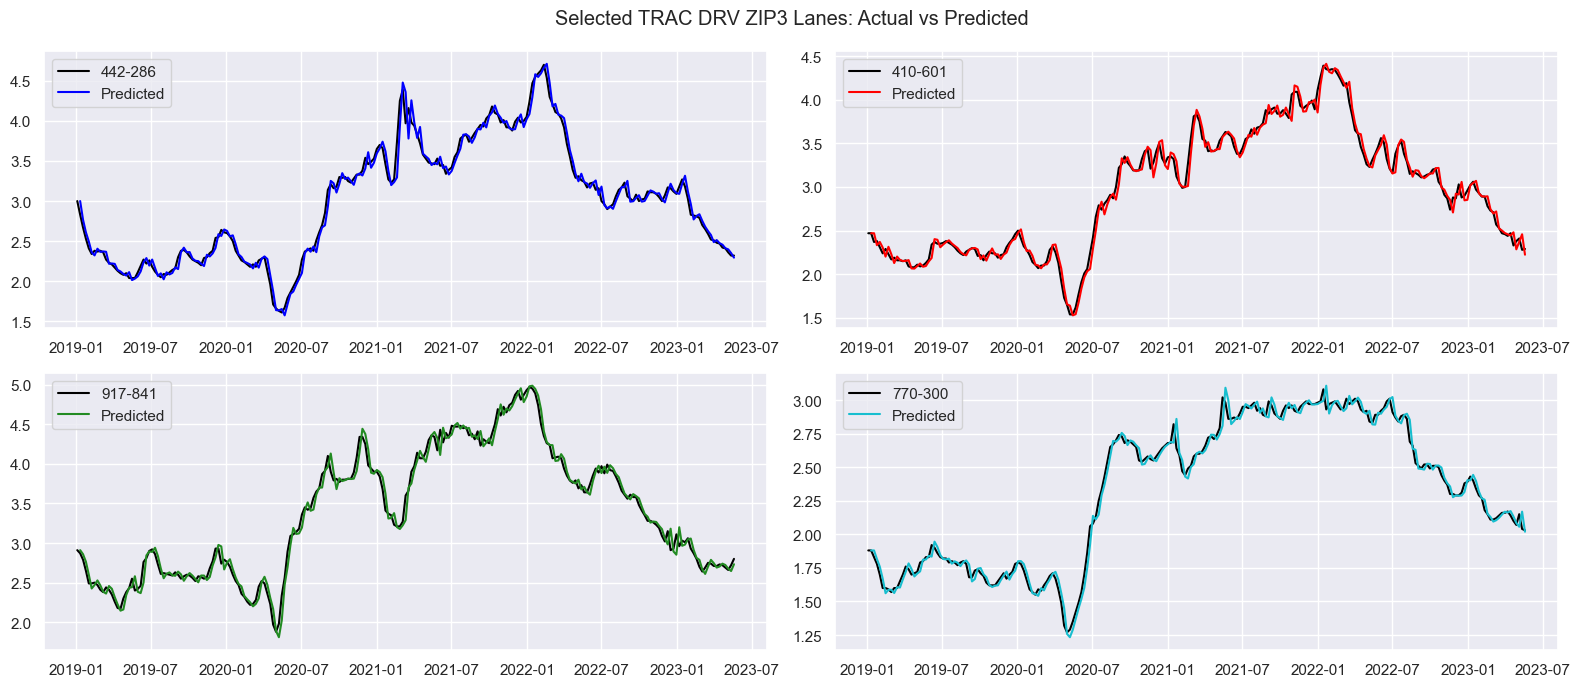

In [36]:
fig = plt.figure(figsize=(16, 7))

plt.suptitle("Selected TRAC DRV ZIP3 Lanes: Actual vs Predicted")
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(df_arima_f["442-286"], label="442-286", color="black")
ax1.plot(df_fitted["442-286"], label="Predicted", color="blue")
# ax1.axhline(y=2.51, color="b", linestyle="--")
plt.legend()
# lane 2
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(df_arima_f["410-601"], label="410-601", color="black")
ax2.plot(df_fitted["410-601"], label="Predicted", color="red")
# ax2.axhline(y=3.82, color="b", linestyle="--")
plt.legend()
# Lane 3
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(df_arima_f["917-841"], label="917-841", color="black")
ax3.plot(df_fitted["917-841"], label="Predicted", color="forestgreen")
# ax3.axhline(y=3.78, color="b", linestyle="--")
plt.legend()
# Lane 4
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(df_arima_f["770-300"], label="770-300", color="black")
ax4.plot(df_fitted["770-300"], label="Predicted", color="tab:cyan")
# ax4.axhline(y=2.12, color="b", linestyle="--")
plt.legend()

[ax.legend(loc=2) for ax in plt.gcf().axes]

plt.tight_layout()

plt.show()

In [100]:
# Chart 3: Dynamic charts:

fig2 = make_subplots(specs=[[{"secondary_y": True}]])
fig2.add_trace(
    go.Scatter(
        x=df_arima_f.index,
        y=df_arima_f["432-296"],
        mode="lines+markers",
        name=" Lane rate",
    ),
    secondary_y=False,
)
fig2.add_trace(
    go.Scatter(
        x=df_fitted.index,
        y=df_fitted["432-296"],
        mode="lines+markers",
        name="One-step ahead forecast",
    ),
    secondary_y=False,
)

# Set title
fig2.update_layout(title_text="[442-286]: One-step ahead Forecast X Lane rate")

# Set legend position
fig2.update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=0.2)
)

fig2.update_layout(autosize=False, width=1800, height=700)

fig2.show()

### Conclusions:

* ARIMA forecasting seems reasonable for short-term forecasts; OIt predicted value within a certain reasonable value.

* Prediction intervals from ARIMA models increase as the forecast horizon increases. For stationary models  they will converge, so that prediction intervals for long horizons are all essentially the same. 

* Why stick with short-term horizons?
  * As with most prediction interval calculations, ARIMA-based intervals tend to be too narrow. This occurs because only the variation in the errors has been accounted for;
  * There is also variation in the parameter estimates, and in the model order, that has not been included in the calculation. In addition, the calculation assumes that the historical patterns that have been modelled will continue into the forecast period.

### Discussions:

* Because of variation in the parameters and model order due to new data, we need to re-run ARIMA everytime we are going to provide a new forecast.
* Build up a up/hold/down market trend indicator: what should be the thersholds?